In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pprint import pprint
from collections import OrderedDict
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import copy
import operator

------------------------------------------------------------------
<h1>Question 1

In [2]:
def MSE(actual,predicted):
    return np.square(np.subtract(actual,predicted)).mean()

<h3>Part 1.1

In [3]:
df = pd.read_csv("Datasets/data.csv")

actual = df['xAttack']
df = df.drop(labels = 'xAttack',axis = 1)

actual_arr = np.array(df)

std_div = np.std(actual_arr,axis = 0)
col_mean = np.mean(actual_arr,axis = 0)

for i in range(actual_arr.shape[0]):
    actual_arr[i] = (actual_arr[i] - col_mean)/std_div

covar = np.cov(actual_arr,rowvar= False)
eigen_val,eigen_vec = np.linalg.eig(covar)

ids = eigen_val.argsort()[::-1] # sorting in descending order

#print(ids)
eigen_val = eigen_val[ids]
eigen_vec = eigen_vec[:,ids]

eigen_sum = sum(eigen_val)

for i in range(29):
    projections = np.matmul(actual_arr,eigen_vec[:,:i])
    reconstructed_data = np.matmul(projections,eigen_vec[:,:i].T)
    mean_error = MSE(actual_arr,reconstructed_data)
    print((i+1),":: ",mean_error*100,"%")

1 ::  100.0 %
2 ::  76.76672220547519 %
3 ::  59.99517510806409 %
4 ::  50.98504093854256 %
5 ::  44.474093839914914 %
6 ::  39.39708648573979 %
7 ::  34.76122058459069 %
8 ::  30.841143469384786 %
9 ::  27.199936821762527 %
10 ::  23.730903552856553 %
11 ::  20.290534211189975 %
12 ::  16.970374872200818 %
13 ::  13.801426909829404 %
14 ::  11.329120901311313 %
15 ::  9.068097478520054 %
16 ::  7.354866419947663 %
17 ::  5.81171899390736 %
18 ::  4.390673014870629 %
19 ::  3.0041291304537503 %
20 ::  1.8137639048019623 %
21 ::  1.0889505035469333 %
22 ::  0.7541702094107017 %
23 ::  0.5249284692074797 %
24 ::  0.3449784126071123 %
25 ::  0.20827390054840786 %
26 ::  0.10861387389182868 %
27 ::  0.05216870771929662 %
28 ::  0.019443228374515287 %
29 ::  0.003462196948982658 %


------------------------------------------------------------
<h3>Part1.2

In [10]:
df = pd.read_csv("Datasets/data.csv")

actual = df['xAttack']
data = copy.deepcopy(df)
df = df.drop(labels = 'xAttack',axis = 1)

actual_arr = np.array(df)

std_div = np.std(actual_arr,axis = 0)
col_mean = np.mean(actual_arr,axis = 0)

for i in range(actual_arr.shape[0]):
    actual_arr[i] = (actual_arr[i] - col_mean)/std_div

covar = np.cov(actual_arr,rowvar= False)
eigen_val,eigen_vec = np.linalg.eig(covar)

ids = eigen_val.argsort()[::-1] # sorting in descending order

#print(ids)
eigen_val = eigen_val[ids]
eigen_vec = eigen_vec[:,ids]

eigen_sum = sum(eigen_val)
projections = np.matmul(actual_arr,eigen_vec[:,:14])

k_cluster = 5
th_count = 999

output = actual.unique()

label = {}
centroids = {}
final_l = {}

for i in range(5):
    label[output[i]] = i

centroids[0] = projections[0]
centroids[1] = projections[100]
centroids[2] = projections[200]
centroids[3] = projections[300]
centroids[4] = projections[400]

for i in range(th_count):
    cluster = {}
    final_l.clear()
    
    for j in range(k_cluster):
        cluster[j] = []
        final_l[j] = []
        
        for k in range(k_cluster):
            final_l[j].append(0)
        
    for j,l in zip(projections,range(projections.shape[0])):
        dist = []
        for k in centroids:
            dist.append(np.linalg.norm(j - centroids[k]))
        classify = dist.index(min(dist))
        cluster[classify].append(j)
        final_l[classify][label[actual[l]]]+= 1
        
    previous_value = {}
        
    for j in range(k_cluster):
        previous_value[j] = centroids[j]
        average = np.mean(cluster[j],axis = 0)
        centroids[j] = average
        
    convergence = True
        
    for j in range(k_cluster):
        if np.sum(abs(previous_value[j] - centroids[j])/abs(centroids[j]) * 100) > 0.001:
            convergence = False
            break
    if convergence == True:
        break
        
print('Total Iterations : ',(i+1))
purity = 0.0
for i in range(k_cluster):
    total = np.sum(final_l[i])
    max_value = max(final_l[i])
    print("Purity of cluster ",(i+1),': ',(max_value/total))
    print("Cluster : ",max(final_l[0].index))
for i in range(k_cluster):
    total = np.sum(final_l[i])
    max_value = max(final_l[i])
    ppurity = max_value/total
    percent = (total*ppurity)/float(len(data))
    purity += percent  
print("Average Purity of Cluster : ",purity)

Total Iterations :  16
Purity of cluster  1 :  0.5348232848232848


TypeError: 'builtin_function_or_method' object is not iterable

In [9]:
final_l

{0: [1029, 24, 820, 51, 0],
 1: [23, 1364, 716, 0, 0],
 2: [11736, 919, 358, 136, 10],
 3: [35, 6807, 76, 0, 0],
 4: [541, 0, 343, 10, 0]}

<h3>Part 3 : GMM

In [6]:
dict_max = {}
GMM = GaussianMixture(n_components=5)
clusters_gmm = GMM.fit_predict(projections)
data['clusters_gmm'] = clusters_gmm
avg_purity = 0.0
for i in range(5):
    t = data[data['clusters_gmm'] == i]
    dict_max[i] = t.groupby('xAttack')['clusters_gmm'].count().idxmax()
    purity_percent = len(t[t['xAttack'] == dict_max[i]])/float(len(t))
    avg_purity = avg_purity + (purity_percent * len(t))/len(data)
    
    print("Clusters with label ",dict_max[i] + " purity_percent :: ",str(purity_percent))

print("Average purity_percent is :: ",avg_purity)

Clusters with label  normal purity_percent ::  0.4834193072955048
Clusters with label  dos purity_percent ::  1.0
Clusters with label  normal purity_percent ::  0.49483985765124555
Clusters with label  normal purity_percent ::  0.8628218510786361
Clusters with label  normal purity_percent ::  1.0
Average purity_percent is ::  0.7953036242899432


<h3>Part 4 : Agglomerative Clustering

In [60]:
dict_max = {}

clustering = AgglomerativeClustering(n_clusters=5,linkage='single')
clusters = clustering.fit_predict(projections)
data['clusters'] = clusters
average_agg = 0.0
for i in range(5):
    t = data[data['clusters'] == i]
    dict_max[i] = t.groupby('xAttack')['clusters'].count().idxmax()
    percent = len(t[t['xAttack'] == dict_max[i]])/float(len(t))
    average_agg += (percent * len(t))/len(data)
    
    print("Cluster with label",dict_max[i] + " purity percentage :: ",str(percent))

print("Average Purity is :: ",average_agg*100)

Cluster with label normal purity percentage ::  0.5346352395053824
Cluster with label probe purity percentage ::  1.0
Cluster with label r2l purity percentage ::  0.6666666666666666
Cluster with label normal purity percentage ::  1.0
Cluster with label normal purity percentage ::  1.0
Average Purity is ::  53.47227778222256


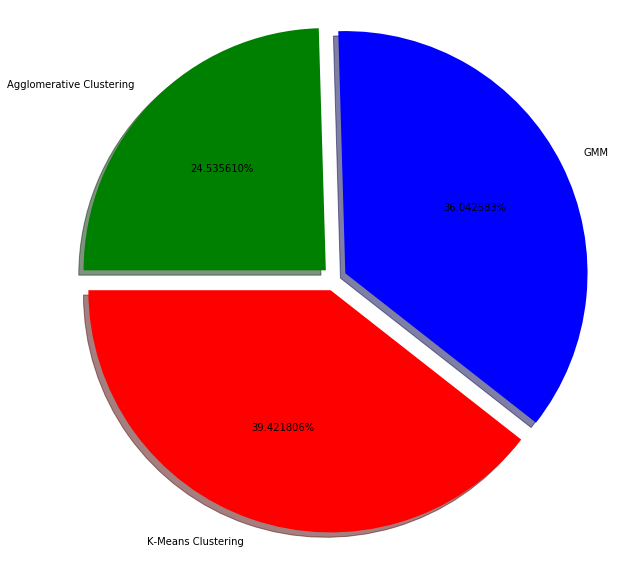

In [61]:
labels = 'K-Means Clustering', 'GMM', 'Agglomerative Clustering'
input_list = [purity,avg_purity,average_agg]
colors = ['red','blue','green']
explode = (0.05, 0.05, 0.05)
 
plt.figure(figsize=(10,10))
plt.pie(input_list, explode=explode, labels=labels, colors=colors,
autopct='%f%%', shadow=True, startangle=180)
 
plt.axis('equal')
plt.show()


<h3>Part 5 : Pie Chart

<b>
    Typically without any preprocessing we cannot use PCA on Categorical data.
    PC analysis is really analysis of eigenvectors of covariance matrix. So the problem is how to calculate the "correct" covariance matrix.PCA is desinged for continuous variables. It tries to minimize variance (=squared deviations). The concept of squared deviations breaks down when you have binary variables.



---------------------------------------------------------------------------------
<h1>Question 2

In [6]:
df = pd.read_csv("Datasets/data_admission.csv")
train_df=df.sample(frac=0.8,random_state=200)
validate_df=df.drop(train_df.index)

validate_label = validate_df['Chance of Admit ']
validate_df = validate_df.drop('Chance of Admit ',axis = 1)

train_df = train_df.drop('Serial No.',axis = 1)
validate_df = validate_df.drop('Serial No.',axis = 1)

train_label = train_df['Chance of Admit ']
train_df = train_df.drop('Chance of Admit ',axis = 1)

train_df = (train_df - train_df.mean())/train_df.std()
validate_df = (validate_df - validate_df.mean())/validate_df.std()

train_label[train_label >= 0.5] = 1
train_label[train_label < 0.5] = 0
validate_label[validate_label >= 0.5] = 1
validate_label[validate_label < 0.5] = 0

# Convert into numpy array's

train_label = [train_label]
train_label = np.array(train_label)
train_label = train_label.T

# Appending 1 to training and testing data frame
one = []
for i in range(len(train_df)):
    one.append(1)
train_df.insert(0,'Ones',one,allow_duplicates=False)
one = []
for i in range(len(validate_df)):
    one.append(1)
validate_df.insert(0,'Ones',one,allow_duplicates=False)

train_df = train_df.values



In [7]:
def sigmoid(z):
    return (1/(1 + np.exp(-z)))

def dot_product(x,B):
    return np.dot(x,B)

def theta(B,x,y):
    m = x.shape[0]
    return np.dot(x.T,sigmoid((dot_product(x,B))) - y)
def helper(B,x,y):
    m = x.shape[0]
    return np.dot(x.T,sigmoid((dot_product(x,B))) - y)


def gradient_descent(B,x,learing_rate,threshold,iteration,y):
    m = y.shape[0]
    for i in range(iteration):
        B_temp = copy.deepcopy(B)
        temp = helper(B,x,y)
        B = B - (learing_rate * temp / m)
#         convergence= True
#         for j in range(len(B)):
#             if abs(B_temp[j][0] - B[j][0] > threshold):
#                 convergence_test = False
#         if convergence:
#             break
    return B

      


In [8]:
B = np.zeros((train_df.shape[1],1))
B = gradient_descent(B,train_df,0.01,0.0001,500,train_label)

test_array = dot_product(validate_df,B)
test_array = np.array(test_array)

predicted = sigmoid(test_array)
predicted[predicted >= 0.5] = 1
predicted[predicted < 0.5] = 0

validate_label = np.array(validate_label).T
accuracy = len([1 for x in range(len(validate_label)) if validate_label[x] == predicted[x]])/len(validate_label)
print("Accuracy : ",accuracy*100,'%')

Accuracy :  97.77777777777777 %


<h3>Part 2.2

In [9]:
def KNN(k, p):
    predictions = []

    for i in validate_df_updated.values:
        dist = []
        itr = 0
        for j in train_df_updated.values:
            euc_distance_list = (abs(i - j)) ** p
            actual_distance = 0
            for z in range(0, len(euc_distance_list)):
                actual_distance += euc_distance_list[z]
            actual_distance = actual_distance ** (1/p)
            dist.append([actual_distance, itr])
            itr += 1
        dist.sort()
        counts_store = []
        for j in range(k):
            counts_store.append(train.values[dist[j][1]][-1])
        labels, label_counts = np.unique(counts_store, return_counts=True)
        predictions.append(labels[np.argmax(label_counts)])

    pred_label, pred_label_counts = np.unique(predictions, return_counts=True)
    tp_counts = [0] * len(pred_label)
    test_label, test_label_counts = np.unique(validate['label'], return_counts=True)
    for i in range(len(predictions)):
        if predictions[i] == validate.values[i][-1]:
            tp_counts[pred_label.tolist().index(predictions[i])] += 1    
    
    prediction_list = OrderedDict()
    
    accuracy = sum(tp_counts) / len(predictions)
    temp = 0
    for i in range(len(pred_label)):
        temp += tp_counts[i] / pred_label_counts[i]
    precision = temp / len(pred_label)
    temp = 0
    for i in range(len(pred_label)):
        temp += tp_counts[i] / test_label_counts[i]
    recall = temp / len(test_label)
    f1 = 2 / ((1 / recall) + (1 / precision))
    prediction_list['accuracy'] = accuracy
    prediction_list['precision'] = precision
    prediction_list['recall'] = recall
    prediction_list['f1_score'] = f1
    
    return prediction_list
   
df = pd.read_csv("Datasets/data_admission.csv")
df.loc[df['Chance of Admit '] >= 0.5, 'Chance of Admit '] = 1
df.loc[df['Chance of Admit '] < 0.5, 'Chance of Admit '] = 0
df['label'] = df['Chance of Admit ']
df = df.drop(['Chance of Admit '],axis=1)
df = df.drop(['Serial No.'],axis=1)
train = df.sample(frac=0.8, random_state=200)
validate = df.drop(train.index)
# train = train.drop('Serial No.',axis = 1)
train_df_updated = train.drop(['label'],axis=1)
validate_df_updated = validate.drop(['label'], axis=1)

prediction_list = KNN(5,2)
for i, (key, value) in enumerate(prediction_list.items()):
    print(key + "::", value*100,' %')
    print("")

accuracy:: 95.55555555555556  %

precision:: 73.83720930232558  %

recall:: 73.83720930232558  %

f1_score:: 73.83720930232558  %



<h3>Part 3 : Changing Thresholds

In [10]:
def General(threshold):
    df = pd.read_csv("Datasets/data_admission.csv")
    train_df=df.sample(frac=0.8,random_state=200)
    validate_df=df.drop(train_df.index)

    validate_label = validate_df['Chance of Admit ']
    validate_df = validate_df.drop('Chance of Admit ',axis = 1)

    train_df = train_df.drop('Serial No.',axis = 1)
    validate_df = validate_df.drop('Serial No.',axis = 1)

    train_label = train_df['Chance of Admit ']
    train_df = train_df.drop('Chance of Admit ',axis = 1)

    train_df = (train_df - train_df.mean())/train_df.std()
    validate_df = (validate_df - validate_df.mean())/validate_df.std()

    train_label[train_label >= threshold] = 1
    train_label[train_label < threshold] = 0
    validate_label[validate_label >= threshold] = 1
    validate_label[validate_label < threshold] = 0

    # Convert into numpy array's

    train_label = [train_label]
    train_label = np.array(train_label)
    train_label = train_label.T

    # Appending 1 to training and testing data frame
    one = []
    for i in range(len(train_df)):
        one.append(1)
    train_df.insert(0,'Ones',one,allow_duplicates=False)
    one = []
    for i in range(len(validate_df)):
        one.append(1)
    validate_df.insert(0,'Ones',one,allow_duplicates=False)

    train_df = train_df.values
    return train_df,validate_df,train_label,validate_label
    
threshold = []
recall = []
precision = []
accuracy = []

for i in range(2,9):
    i*=0.1
    train_df,validate_df,train_label,test_label = General(i)
    B = np.zeros((train_df.shape[1],1))
    B = gradient_descent(B,train_df,0.01,0.0001,500,train_label)

    test_array = dot_product(validate_df,B)
    test_array = np.array(test_array)

    predicted = sigmoid(test_array)
    for y in range(len(predicted)):
        if predicted[y] >= i:
            predicted[y] = 1
        else:
            predicted[y] = 0
    threshold.append(i)
    validate_label = np.array(validate_label).T
    accuracy.append(metrics.accuracy_score(validate_label,predicted))
    precision.append(metrics.precision_score(validate_label,predicted))
    recall.append(metrics.recall_score(validate_label,predicted))


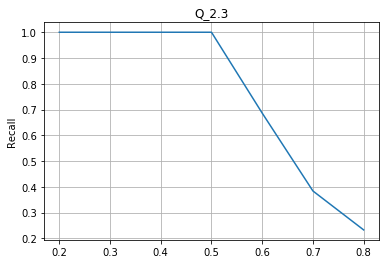

In [67]:
plt.plot(threshold, recall)
# plt.plot(threshold,precision)
# plt.xlabel('Thresold')
plt.ylabel('Recall')
plt.title('Q_2.3')
# plt.legend(['Recall', 'Precision'], loc='upper left')
plt.grid(True)

plt.show()

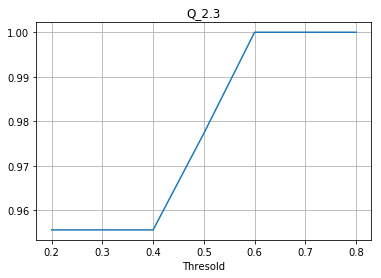

In [68]:
# plt.plot(threshold, recall)
plt.plot(threshold,precision)
plt.xlabel('Thresold')
# plt.ylabel('Recall')
plt.title('Q_2.3')
# plt.legend(['Recall', 'Precision'], loc='upper left')
plt.grid(True)

plt.show()

---------------------------------------------------------------------------
<h1>Question 3

<h2>One vs All

In [13]:
df = pd.read_csv("Datasets/data_wine.csv")

train = df.sample(frac = 0.8, random_state = 200)
validate = df.drop(train.index)

te = train['quality']
train = train.drop(labels = 'quality', axis = 1)
train = (train - train.mean())/train.std()
train.insert(0, 'quality', te, allow_duplicates = False)

te = validate['quality']
validate = validate.drop(labels = 'quality', axis = 1)
validate = (validate - validate.mean())/validate.std()
validate.insert(0, 'quality', te, allow_duplicates = False)

classification_list = train['quality'].unique()
ctheta = []

def out_t(temp,val) :
    li = []
    for i in temp :
        if(i == val) :
            li.append(1)
        else :
            li.append(0)

    return li

for i in classification_list:
    y_train_act = train['quality']
    train_df = train.drop('quality', axis = 1)
    mytemp = y_train_act.tolist()
    y_train_act = np.array(out_t(mytemp,i))
    li = []
    for p in range(len(train.index)) :
        li.append(1)
    train_df.insert(0, 'new_column', li, allow_duplicates = False)
    train_df = train_df.values
    theta = np.zeros((train_df.shape[1],1))
    y_train_act = [y_train_act]
    y_train_act = np.array(y_train_act)
    y_train_act = y_train_act.T
    theta = gradient_descent(theta,train_df,0.00001,0.01,1000,y_train_act)
    theta.tolist()
    ctheta.append(theta)

ctheta = np.array(ctheta)

ctheta = ctheta[:,:,0]



li = []
for x in range(len(validate.index)) :
    li.append(1)
y_test_act = validate['quality']
validate.insert(0, 'new_column', li, allow_duplicates = False)
validate = validate.drop('quality', axis = 1)

y_pred = []
for i, rows in validate.iterrows() :
    templi = []
    for j in range(ctheta.shape[0]) :
        rows = np.array(rows)
        t = np.matmul(ctheta[j],rows)
        t = sigmoid(t)
        templi.append(t)


    index, value = max(enumerate(templi), key=operator.itemgetter(1))
    y_pred.append(classification_list[index])
print("Accuracy :: "   , metrics.accuracy_score(y_pred,y_test_act)*100,'%')

Accuracy ::  46.59863945578231 %


<h3>One vs One

In [14]:
df = pd.read_csv("Datasets/data_wine.csv")

train = df.sample(frac = 0.8, random_state = 200)
validate = df.drop(train.index)

te = train['quality']
train = train.drop(labels = 'quality', axis = 1)
train = (train - train.mean())/train.std()
train.insert(0, 'quality', te, allow_duplicates = False)

te = validate['quality']
validate = validate.drop(labels = 'quality', axis = 1)
validate = (validate - validate.mean())/validate.std()
validate.insert(0, 'quality', te, allow_duplicates = False)

ulist = train['quality'].unique()
ctheta = []
classification_list = []
for i in range(len(ulist)-1):
    for j in range(i+1,len(ulist)) :
        classification_list.append((ulist[i],ulist[j]))

for i in classification_list:
    temp1 = train[train['quality'] == i[0]]
    temp2 = train[train['quality'] == i[1]]
    frames = [temp1,temp2]
    train_df = pd.concat(frames)
    y_train_act = train_df['quality']
    train_df = train_df.drop('quality', axis = 1)
    y_train_act[y_train_act == i[0]] = 1
    y_train_act[y_train_act == i[1]] = 0
    li = []
    for y in range(len(train_df.index)) :
        li.append(1)

    train_df.insert(0, 'new_column', li, allow_duplicates = False)

    train_df = train_df.values
    theta = np.zeros((train_df.shape[1],1))
    y_train_act = [y_train_act]
    y_train_act = np.array(y_train_act)
    y_train_act = y_train_act.T
    theta = gradient_descent(theta,train_df,0.00001,0.01,1000,y_train_act)
    theta.tolist()
    ctheta.append(theta)
    
ctheta = np.array(ctheta)
ctheta = ctheta[:,:,0]

li = []
for y in range(len(validate.index)) :
    li.append(1)
y_test_act = validate['quality']
validate.insert(0, 'new_column', li, allow_duplicates = False)
validate = validate.drop('quality', axis = 1)

y_pred = []
for i, rows in validate.iterrows() :
    templi = []
    for j in range(ctheta.shape[0]) :
        rows = np.array(rows)
        t = np.matmul(ctheta[j],rows)
        t = sigmoid(t)
        if(t >= 0.5) :

            templi.append(classification_list[j][0])

        else :
            templi.append(classification_list[j][1])

    value = max(set(templi), key=templi.count)
    y_pred.append(value)
print("Accuracy :: "   , metrics.accuracy_score(y_pred,y_test_act)*100,'%')


Accuracy ::  46.59863945578231 %
